# CORAL Implementation Recipe

This notebook provides a brief overview of the relevant parts of CORAL that distinguish from a "regular" deep neural network for classification. The purpose of this overview is to provide a succinct resource that may help other researchers in porting the CORAL framework to other, non-PyTorch code bases (such as TensorFlow, Keras, MXnet, etc.). 

## 1) Implement a function that converts class labels

- In contrast to regular cross entropy-based classification approaches, CORAL operates on binary tasks rather than integer class labels (or one-hot encoding representations thereof); hence, we have to convert class labels into the respective representation, which is illustrated here. 
- To provide an example, suppose you have a dataset consisting of 5 classes; consequently, the class labels are 0, 1, 2, 3, and 4.
- The following `label_to_levels` function converts class labels into the binary task representation required by CORAL, we call them "levels:"

In [1]:
import torch


def label_to_levels(label, num_classes):
    levels = [1]*label + [0]*(num_classes - 1 - label)
    levels = torch.tensor(levels, dtype=torch.float32)
    return levels

- To continue with the example, assume we have a dataset of 3 training examples with class labels 2, 1, 4
- The converted labels would look as follows:

In [2]:
NUM_CLASSES = 5

levels = []
class_labels = [2, 1, 4]

for label in class_labels:
    levels_from_label = label_to_levels(label, num_classes=NUM_CLASSES)
    levels.append(levels_from_label)

levels = torch.stack(levels)
levels

tensor([[1., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 1., 1., 1.]])

## 2) Implement the loss function

As outlined in the paper, the loss function is defined as

$$
\begin{aligned}
L(\mathbf{W}, \mathbf{b})=& \\
&-\sum_{i=1}^{N} \sum_{k=1}^{K-1} \lambda^{(k)}\left[\log \left(s\left(g\left(\mathbf{x}_{i}, \mathbf{W}\right)+b_{k}\right)\right) y_{i}^{(k)}\right.\\
&\left.+\log \left(1-s\left(g\left(\mathbf{x}_{i}, \mathbf{W}\right)+b_{k}\right)\right)\left(1-y_{i}^{(k)}\right)\right]
\end{aligned}
$$

- In the paper, we used a uniform task importance weight $\lambda$ (this means, all binary tasks were treated equally); this can be achieved by using a vectors of 1's as the task importance weights.

In [3]:
importance_weights = torch.ones(NUM_CLASSES-1, dtype=torch.float)

- The loss function itself, based on the equation above, can be implemented as follows:

In [4]:
import torch.nn.functional as F


def loss_fn1(logits, levels, imp):
    val =  -torch.sum((torch.log(torch.sigmoid(logits))*levels + 
             torch.log(1 - torch.sigmoid(logits))*(1-levels))*imp,
           dim=1)
    return torch.mean(val)    

- To apply it to a concrete example, we use the previous "levels" and some made-up logit values (these logits values would be the neural network outputs).
- Note that the rows represent the training examples, whereas the columns represent the logit value for each binary task:

In [5]:
logits = torch.tensor([[2.1, 1.8, -2.1, -1.8],
                       [1.9, -1., -1.5, -1.3],
                       [1.9, 1.8, 1.7, 1.6]])

In [6]:
loss_fn1(logits=logits, 
         levels=levels,
         imp=importance_weights)

tensor(0.6920)

In practice, we found the loss function can be numerically more stable if we rewrite 


(1) 

```python
torch.log(torch.sigmoid(logits))*levels
```

as 

```python 
F.logsigmoid(logits)*levels
```

and (2)

```python 
torch.log(1 - torch.sigmoid(logits))*(1-levels)
```

as 

```python 
(F.logsigmoid(logits) - logits)*(1-levels)
```

Note that (2) if valid since

$$
\begin{aligned}
log\bigg(\frac{e^x}{1+e^x}\bigg) - x &= log\bigg(\frac{e^x}{1+e^x}\bigg) - log(e^x)\\
&= log\bigg(\frac{1}{1+e^x}\bigg)\\
&= log\bigg(1-\frac{e^x}{1+e^x}\bigg)
\end{aligned}
$$

- Hence, in practice, we recommend using the following loss function (which produces the same results as the one outlined above):

In [7]:
def loss_fn2(logits, levels, imp):
    val = (-torch.sum((F.logsigmoid(logits)*levels
                      + (F.logsigmoid(logits) - logits)*(1-levels))*imp,
           dim=1))
    return torch.mean(val)

In [8]:
loss_fn2(logits=logits, 
         levels=levels,
         imp=importance_weights)

tensor(0.6920)

## 3) Modify the neural network architecture

The modification that has to be made to an existing deep neural network classifier is relatively simple as it only affects the last layer (i.e., output layer). In particular, the last fully connected layer has to be changed.

In PyTorch, this means 

(1) changing the last fully connected layer

```python
...
self.fc = nn.Linear(input_size, num_classes)
```

to

```python
...
self.fc = nn.Linear(input_size, 1, bias=False)
self.linear_1_bias = nn.Parameter(torch.zeros(self.num_classes-1).float())
```

(2) and changing the forward pass from

```python
...
logits = self.fc(x)
probas = F.softmax(logits, dim=1)
return logits, probas
```
        
to

```python
logits = self.fc(x) + self.linear_1_bias
probas = torch.sigmoid(logits)
return logits, probas
```

### Test with pre-defined weights

- Below is an example that can be used to test the implementation given some pre-defined weights (these are usually randomly initialized in a real application) and layer inputs.

In [9]:
num_classes = 5

###################################################
# initialize fully connected layer without bias
fc = torch.nn.Linear(10, 1, bias=False)

# overwrite weight for reproducibility
fc.weight = torch.nn.Parameter(
             torch.tensor([[ 0.3019, -0.1284, 
                            -0.2542, -0.0886,  
                            0.1354,  0.1257, 
                            -0.2183, -0.2714,
                            -0.1859,  0.0035]], 
                          requires_grad=True)
)
####################################################

# Initialize bias
linear_1_bias = torch.nn.Parameter(torch.zeros(num_classes-1).float())

# Initialize 2 random training layer inputs
example_inputs = torch.tensor([[0.2769, 0.5538, 0.8187, 0.5455, 
                                0.3085, 0.7225, 0.7978, 0.8664, 0.2754, 0.5541],
                               [0.4267, 0.5409, 0.2538, 0.1381, 
                                0.3889, 0.7500, 0.0249, 0.1347, 0.0494, 0.0935]])

# Compute outputs
logits = fc(example_inputs) + linear_1_bias
probas = torch.sigmoid(logits)

print('Logits:')
print('1st training example:', logits[0])
print('2nd training example:', logits[0])

print('\n\nProbas:')
print('1st training example:', probas[0])
print('2nd training example:', probas[0])

Logits:
1st training example: tensor([-0.5699, -0.5699, -0.5699, -0.5699], grad_fn=<SelectBackward>)
2nd training example: tensor([-0.5699, -0.5699, -0.5699, -0.5699], grad_fn=<SelectBackward>)


Probas:
1st training example: tensor([0.3613, 0.3613, 0.3613, 0.3613], grad_fn=<SelectBackward>)
2nd training example: tensor([0.3613, 0.3613, 0.3613, 0.3613], grad_fn=<SelectBackward>)


- Note that for each of the 2 training examples, the values are the same for all output units, because the network hasn't learned the bias parameter, yet. Assuming the learned bias parameter vector is [0, 1, 2, 3], you should see different outputs:

In [10]:
linear_1_bias = torch.nn.Parameter(torch.tensor([0., 1., 2., 3.]))
logits = fc(example_inputs) + linear_1_bias
probas = torch.sigmoid(logits)

print('Logits:')
print('1st training example:', logits[0])
print('2nd training example:', logits[0])

print('\n\nProbas:')
print('1st training example:', probas[0])
print('2nd training example:', probas[0])

Logits:
1st training example: tensor([-0.5699,  0.4301,  1.4301,  2.4301], grad_fn=<SelectBackward>)
2nd training example: tensor([-0.5699,  0.4301,  1.4301,  2.4301], grad_fn=<SelectBackward>)


Probas:
1st training example: tensor([0.3613, 0.6059, 0.8069, 0.9191], grad_fn=<SelectBackward>)
2nd training example: tensor([0.3613, 0.6059, 0.8069, 0.9191], grad_fn=<SelectBackward>)


## 4) Evaluate the neural network

Computing performance metrics such as the mean absolute error, or simply obtaining class labels, requires a small modification. Whereas in cross entropy-based classifiers, we obtain the class labels via

```python
logits, probas = model(features)
_, predicted_labels = torch.max(probas, 1)
```

we can change these lines to

```python
logits, probas = model(features)
predict_levels = probas > 0.5
predicted_labels = torch.sum(predict_levels, dim=1)
```

in CORAL.

Based on the `probas` from the example above, *4) Evaluate the neural network*, we can compute the predicted labels as follows:

In [19]:
predict_levels = probas > 0.5
predicted_labels = torch.sum(predict_levels, dim=1)
predicted_labels

tensor([3, 4])

## 5) Example Run and Code Checks

- Below is an example running the CORAL layer in a very simple convolutional neural network on MNIST.
- Note that MNIST is not an ordinal classification task; however, we use it here for simplicity, since it's a dataset that is built into most deep learning frameworks already and serves as a good start for debugging.

In [12]:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

##########################
### SETTINGS
##########################

# Hyperparameters
random_seed = 1
learning_rate = 0.05
num_epochs = 2
batch_size = 128

# Architecture
NUM_CLASSES = 10

# Other
importance_weights = torch.ones(NUM_CLASSES-1, dtype=torch.float)


##########################
### MNIST DATASET
##########################


# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          drop_last=True,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         drop_last=True,
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


In [13]:
class ConvNet(torch.nn.Module):

    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        
        
        self.conv_1 = torch.nn.Conv2d(in_channels=1,
                                      out_channels=3,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1)

        self.pool_1 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         padding=0)                                

        self.conv_2 = torch.nn.Conv2d(in_channels=3,
                                      out_channels=6,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1)           
                  
        self.pool_2 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         padding=0)

        #######################
        ##### CORAL LAYER #####
        ###---------------------------------------------------------------------------###
        self.fc = torch.nn.Linear(294, 1, bias=False)
        self.linear_1_bias = torch.nn.Parameter(torch.zeros(num_classes-1).float())
        ###---------------------------------------------------------------------------###


        
    def forward(self, x):
        out = self.conv_1(x)
        out = F.relu(out)
        out = self.pool_1(out)

        out = self.conv_2(out)
        out = F.relu(out)
        out = self.pool_2(out)
        
        # flatten
        out = out.view(out.size(0), -1)
        
        #######################
        ##### CORAL LAYER #####
        ###--------------------------------------------------------------------###
        logits = self.fc(out) + self.linear_1_bias
        probas = torch.sigmoid(logits)
        ###--------------------------------------------------------------------###
        
        return logits, probas

    
torch.manual_seed(random_seed)
model = ConvNet(num_classes=NUM_CLASSES)

optimizer = torch.optim.Adam(model.parameters())

In [14]:
for epoch in range(num_epochs):
    
    model = model.train()
    for batch_idx, (features, class_labels) in enumerate(train_loader):

        
        ###################################
        ##### CORAL LABEL CONVERSION #####
        ###------------------------------START-----------------------------------###
        levels = []
        for label in class_labels:
            levels_from_label = label_to_levels(label, num_classes=NUM_CLASSES)
            levels.append(levels_from_label)

        levels = torch.stack(levels)
        ###------------------------------END-------------------------------------###

        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        
        
        ###################################
        ##### CORAL LOSS ##################
        ###------------------------------START-----------------------------------###  
        cost = loss_fn2(logits, levels, imp=importance_weights)
        ###------------------------------END-------------------------------------###        
        
        
        optimizer.zero_grad()
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 150:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))

Epoch: 001/002 | Batch 000/468 | Cost: 6.2465
Epoch: 001/002 | Batch 150/468 | Cost: 4.8635
Epoch: 001/002 | Batch 300/468 | Cost: 4.6088
Epoch: 001/002 | Batch 450/468 | Cost: 3.9067
Epoch: 002/002 | Batch 000/468 | Cost: 4.1401
Epoch: 002/002 | Batch 150/468 | Cost: 4.0048
Epoch: 002/002 | Batch 300/468 | Cost: 3.5715
Epoch: 002/002 | Batch 450/468 | Cost: 3.6428


### Sanity checks

- Both the levels (converted labels) and logits (model outputs) should have the same dimension: `batch_size x num_classes-1`. In this case, 128 x 9 (since there are 10 classes in MNIST).

In [15]:
print(f"Logits size: {logits.size()}")
print(f"Levels size: {levels.size()}")

Logits size: torch.Size([128, 9])
Levels size: torch.Size([128, 9])


Since the weight parameters are shared among all output tasks, the number of parameters should be equal to the number of input parameters, in this case 294.

In [16]:
print(f"Input, params: {model.fc.weight.size(1)}")
print(f"Outputs, params: {model.fc.weight.size(0)}")

Input, params: 294
Outputs, params: 1


The bias should be equal to NUM_CLASSES-1, that is, 9 in this case:

In [17]:
print(f"Number of bias units: {model.linear_1_bias.size()}")

Number of bias units: torch.Size([9])


- The learned bias values of the CORAL layer should now be in descending order:

In [18]:
model.linear_1_bias

Parameter containing:
tensor([ 0.8481,  0.8062,  0.7222,  0.4642, -0.0421, -0.4887, -0.7205, -0.8064,
        -0.8451], requires_grad=True)

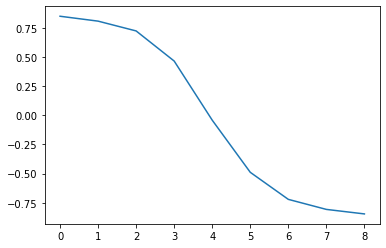

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(model.linear_1_bias.detach().numpy())
plt.show()